In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from datasets import Dataset

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
data= pd.read_csv('Combined_Data.csv')

In [ ]:
data.sample(10)

,Unnamed: 0,statement,status
525,525,restless restless accompanying,Anxiety
50534,50534,Bipolar depression got off meds 3 years ago I ...,Bipolar
43424,43424,hooray for the ever so reliable signalflare se...,Normal
47346,47346,My concentration is incredibly poor Don't know...,Depression
32663,32663,not me. i want to play for the dodgers.,Normal
7314,7314,Fuck I wish I was not so much of a damn coward...,Suicidal
16079,16079,"I wish I was not born human, but rather an ani...",Depression
29744,29744,Generally good marriage. We can both be stubbo...,Normal
43184,43184,tommcfly hey saw u guy play pushover didn t ge...,Normal
42233,42233,should ve been asleep two hour ago,Normal


In [ ]:
data.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [ ]:
data.shape

(53043, 3)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isnull().sum()

,0
Unnamed: 0,0
statement,0
status,0


In [ ]:
data.shape

(52681, 3)

In [ ]:
data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data= data.sample(n=6000, random_state=42).reset_index(drop=True)
data

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words= set(stopwords.words('english'))

def clean_statement(text):
  #lowercasing
  text= text.lower()

  #removing everything except letters
  text= re.sub(r"[^a-zA-Z\s]",'',text)

  #tokenization(splitting)
  words= text.split()
  words= [word for word in words if word not in stop_words]

  return " ".join(words)


data['statement']= data['statement'].apply(clean_statement)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['status'].value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros= RandomOverSampler(sampling_strategy='auto',random_state=42)
X= data.drop(columns=['status'])
y= data['status']

X_resampled, y_resampled= ros.fit_resample(X,y)

data= pd.concat([X_resampled,y_resampled],axis=1)

print(data['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


In [ ]:
data.shape

(13258, 2)

In [ ]:
label_encoder= LabelEncoder()
data['label']= label_encoder.fit_transform(data['status'])
data

,statement,status,label
0,im lazy complain ba ihh,Normal,3
1,think wifi iphone broken quot connect quot act...,Normal,3
2,good tracking apps ive trying find apps track ...,Bipolar,1
3,recently looked reddit found place actually qu...,Depression,2
4,thats favorite thing,Normal,3
...,...,...,...
13253,cannot afford therapist social anxiety depress...,Suicidal,6
13254,would like die simplei would really like suffe...,Suicidal,6
13255,death day time set affairs might even get bedr...,Suicidal,6
13256,hard seeing others live life would kill know w...,Suicidal,6


In [ ]:
data['label'].unique()

array([3, 1, 2, 6, 5, 4, 0])

In [ ]:
train_texts, test_texts, train_labels, test_labels= train_test_split(data['statement'],data['label'],test_size=0.2,random_state=42)

In [ ]:
max([len(text) for text in data['statement']])

5893

In [ ]:
#Tokenization using BERT
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings= tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings= tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
#Convert to Dataset format
train_dataset= Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'],'labels': train_labels.tolist()})
test_dataset= Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'],'labels': test_labels.tolist()})

In [28]:
train_dataset[0]

{'input_ids': [101,
  3087,
  2842,
  5292,
  2573,
  20906,
  10521,
  19500,
  16570,
  4383,
  2492,
  7632,
  3071,
  2451,
  2307,
  2490,
  2420,
  10047,
  3110,
  2919,
  4921,
  2063,
  3160,
  2568,
  19511,
  4921,
  2063,
  6915,
  10089,
  2972,
  2166,
  3985,
  11441,
  1059,
  11721,
  2094,
  2357,
  19960,
  11493,
  7242,
  2144,
  2028,
  6922,
  10089,
  23666,
  5729,
  1044,
  22571,
  11663,
  15422,
  4360,
  13844,
  14071,
  2063,
  2521,
  3342,
  5700,
  3638,
  6933,
  3566,
  10215,
  4456,
  5996,
  10215,
  7870,
  2036,
  15677,
  3342,
  3666,
  6547,
  11616,
  4178,
  2690,
  2082,
  3565,
  4658,
  3666,
  2052,
  2765,
  2101,
  10215,
  3649,
  4295,
  2792,
  2956,
  2211,
  3773,
  19294,
  18146,
  2288,
  4699,
  5177,
  7355,
  2101,
  2419,
  3037,
  23130,
  4295,
  2152,
  2082,
  2776,
  2357,
  22822,
  8458,
  2098,
  2476,
  2146,
  23809,
  7274,
  27794,
  3092,
  2893,
  8324,
  3014,
  23700,
  2358,
  29100,
  8065,
  3076,
  838

In [35]:
#Fine tune Model
model= BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=len(label_encoder.classes_))

training_args= TrainingArguments(
    output_dir='./results',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    warmup_steps=500,
    metric_for_best_model='eval_loss',
    save_total_limit=3,
    gradient_accumulation_steps=2
)

trainer= Trainer(
    model= model,
    args= training_args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: beeezzzsarda (beeezzzsarda-galgotias-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.968400
20,1.957400
30,1.942900
40,1.937300
50,1.932700
60,1.915100
70,1.922400
80,1.894700
90,1.877200
100,1.850400


TrainOutput(global_step=1660, training_loss=0.5165175859288997, metrics={'train_runtime': 1866.1214, 'train_samples_per_second': 28.417, 'train_steps_per_second': 0.89, 'total_flos': 5450549081100000.0, 'train_loss': 0.5165175859288997, 'epoch': 5.0})

In [37]:
output = trainer.predict(test_dataset)

predictions = output.predictions
labels = output.label_ids
metrics = output.metrics  # optional

predicted_labels = np.argmax(predictions, axis=1)


                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98       342
             Bipolar       0.99      1.00      0.99       397
          Depression       0.78      0.74      0.76       369
              Normal       0.94      0.91      0.92       401
Personality disorder       0.99      1.00      1.00       386
              Stress       0.96      1.00      0.98       361
            Suicidal       0.79      0.80      0.80       396

            accuracy                           0.92      2652
           macro avg       0.92      0.92      0.92      2652
        weighted avg       0.92      0.92      0.92      2652



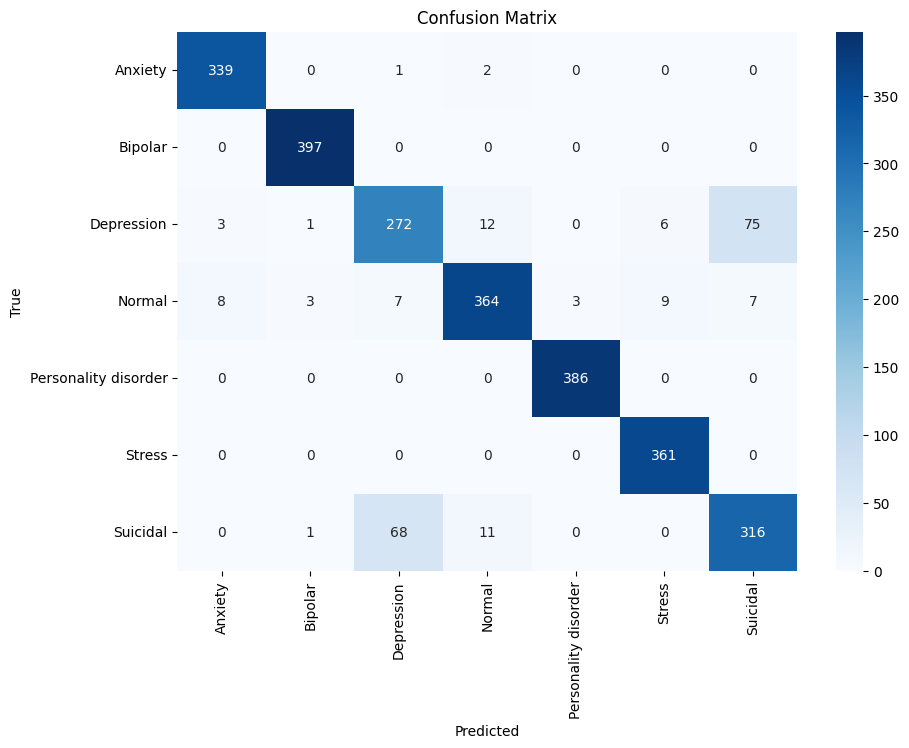

In [39]:
print(classification_report(test_labels,predicted_labels,target_names=label_encoder.classes_))

cm= confusion_matrix(test_labels,predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**92%------>ACCURACY**

In [40]:
trainer.save_model('/content/trainer')
tokenizer.save_pretrained('/content/tokenizer')

import pickle
pickle.dump(label_encoder, open('/content/label_encoder.pkl','wb'))



In [44]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model= AutoModelForSequenceClassification.from_pretrained('/content/trainer')
tokenizer= AutoTokenizer.from_pretrained('/content/tokenizer')

label_encoder= pickle.load(open('/content/label_encoder.pkl','rb'))

In [52]:
#Detection System
import torch
def detection(text):
  text= clean_statement(text)
  inputs= tokenizer(text,return_tensors='pt',padding=True, truncation=True,max_length=200)
  outputs= model(**inputs)
  logits= outputs.logits
  prediction_label= torch.argmax(logits,dim=1).item()

  return label_encoder.inverse_transform([prediction_label])[0]

text="I am feeling very stressful and having headache"
detection(text)

'Stress'

In [56]:
# Sample texts
texts = [
    "I am feeling very stressful and having headache",
    "I am so happy and relaxed today",
    "I can't sleep and my mind is racing",
    "Feeling tired but calm",
    "I am anxious about tomorrow's meeting",
    "I feel like dying"
]

# Run detection for each text
for t in texts:
    result = detection(t)
    print(f"Text: {t}")
    print(f"Detected: {result}")
    print("-" * 50)


Text: I am feeling very stressful and having headache
Detected: Stress
--------------------------------------------------
Text: I am so happy and relaxed today
Detected: Normal
--------------------------------------------------
Text: I can't sleep and my mind is racing
Detected: Normal
--------------------------------------------------
Text: Feeling tired but calm
Detected: Normal
--------------------------------------------------
Text: I am anxious about tomorrow's meeting
Detected: Anxiety
--------------------------------------------------
Text: I feel like dying
Detected: Normal
--------------------------------------------------
